In [55]:
import pandas as pd

# Beispiel: Lesen der Daten aus einer Datei
# Pfad zur Datei
file_path = r"C:\Users\bernh\Downloads\drive-download-20240908T150007Z-001\WitMotion New Software\WitMotion(V2024.8.12.4)\Record\2024-09-15\09-51-45-747\data_0.txt"
# "C:\Users\bernh\Downloads\drive-download-20240908T150007Z-001\WitMotion New Software\WitMotion(V2024.8.12.4)\Record\2024-09-15\09-51-45-747\data_0.txt"
# "C:\Users\bernh\Downloads\drive-download-20240908T150007Z-001\WitMotion New Software\WitMotion(V2024.8.12.4)\Record\2024-09-15\05-11-18-527\data_0.txt"
# Daten in den DataFrame laden, mit Tabulator als Trennzeichen
df = pd.read_csv(file_path, sep='\t', index_col=False)


# Überprüfen der Spaltennamen nach dem Zurücksetzen des Index
# print("Spaltennamen nach Index-Zurücksetzung:", df.columns)

# Die ersten paar Zeilen nach der Anpassung anzeigen
print(df.head())

#_# Ersetzen von Kommas durch Punkte in spezifischen Spalten
#_df['Chip Time()'] = df['Chip Time()'].str.replace(',', '.').astype(float)
#_# ACCELERATION:
df['Acceleration X(g)'] = df['Acceleration X(g)'].str.replace(',', '.').astype(float)
df['Acceleration Y(g)'] = df['Acceleration Y(g)'].str.replace(',', '.').astype(float)
df['Acceleration Z(g)'] = df['Acceleration Z(g)'].str.replace(',', '.').astype(float)
#_# ANGELS
df['Angle X(°)'] = df['Angle X(°)'].str.replace(',', '.').astype(float)
df['Angle Y(°)'] = df['Angle Y(°)'].str.replace(',', '.').astype(float)
df['Angle Z(°)'] = df['Angle Z(°)'].str.replace(',', '.').astype(float)
# ANGULAR VELOSITY
df['Angular velocity X(°/s)'] = df['Angular velocity X(°/s)'].str.replace(',', '.').astype(float)
df['Angular velocity Y(°/s)'] = df['Angular velocity Y(°/s)'].str.replace(',', '.').astype(float)
df['Angular velocity Z(°/s)'] = df['Angular velocity Z(°/s)'].str.replace(',', '.').astype(float)

# Alle numerischen Spalten mit Kommas in Punkten umwandeln
# df = df.replace({',': '.'}, regex=True).astype(float)

# print(df)

            Time Device name  Chip Time() Acceleration X(g) Acceleration Y(g)  \
0   09:51:45.800       COM12          NaN            -0,021             0,017   
1   09:51:45.900       COM12          NaN            -0,021             0,017   
2   09:51:46.000       COM12          NaN            -0,021             0,018   
3   09:51:46.099       COM12          NaN            -0,021             0,017   
4   09:51:46.199       COM12          NaN            -0,021             0,017   

  Acceleration Z(g) Angular velocity X(°/s) Angular velocity Y(°/s)  \
0             1,008                   0,000                   0,000   
1             1,008                   0,000                   0,000   
2             1,008                   0,000                   0,000   
3             1,008                   0,000                   0,000   
4             1,009                   0,000                   0,000   

  Angular velocity Z(°/s) Angle X(°)  ... Angle of course(°) GPS height(m)  \
0       

### eigentliche Zeit-Differenz-Berechnung

In [56]:
import numpy as np
from datetime import datetime

time = df['Time'].values  # Zeitspalte falls vorhanden

# Dein NumPy-Array mit Zeitstempeln als Strings
# time = np.array([' 18:06:05.104', ' 18:06:05.247', ' 18:06:05.304', ' 18:06:05.403'])

# Entferne führende und nachfolgende Leerzeichen aus der 'Time'-Spalte
df['Time'] = df['Time'].str.strip()
 
# Konvertiere die 'Time'-Spalte in das Datetime-Format
df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S.%f')

# Zeitdifferenzen berechnen und in einer neuen Spalte speichern
df['Delta_t'] = df['Time'].diff().dt.total_seconds()
 
# print(df['Delta_t'])

Berechnung der Rotationsmatrix:

In [3]:
import numpy as np

def rotation_matrix(roll, pitch, yaw):
    roll = np.deg2rad(roll)
    pitch = np.deg2rad(pitch)
    yaw = np.deg2rad(yaw)

    R_x = np.array([[1, 0, 0],
                    [0, np.cos(roll), -np.sin(roll)],
                    [0, np.sin(roll), np.cos(roll)]])

    R_y = np.array([[np.cos(pitch), 0, np.sin(pitch)],
                    [0, 1, 0],
                    [-np.sin(pitch), 0, np.cos(pitch)]])

    R_z = np.array([[np.cos(yaw), -np.sin(yaw), 0],
                    [np.sin(yaw), np.cos(yaw), 0],
                    [0, 0, 1]])

    R = R_z @ R_y @ R_x
    return R

Transformiere die Beschleunigungsdaten:

Berechne die globale Beschleunigung, indem du die lokale Beschleunigung mit der Rotationsmatrix multiplizierst:

In [48]:
def transform_acceleration(acc_local, roll, pitch, yaw):
    R = rotation_matrix(roll, pitch, yaw)
    acc_global = R @ acc_local
    return acc_global

Integration zur Positionsbestimmung
Berechne die Geschwindigkeit und Position: Nach der Transformation der Beschleunigung in das globale Koordinatensystem, kannst du die Geschwindigkeit und die Position durch Integration berechnen. Dazu benötigst du die Zeitdifferenz (Delta_t), um die Beschleunigung in Geschwindigkeit und dann die Geschwindigkeit in Position zu integrieren.

Berechnung der Geschwindigkeit und Position:

In [49]:
def integrate(accelerations, delta_t):
    velocity = np.cumsum(accelerations * delta_t)
    position = np.cumsum(velocity * delta_t)
    return velocity, position


Berücksichtigung der Erdbeschleunigung

In [50]:
def adjust_for_gravity(acc_global, gravity=9.81):
    acc_global[2] -= gravity  # Annahme: Z-Achse ist vertikal
    return acc_global


### Lese die Daten aus dem DataFrame und wende die Funktionen an

In [ ]:
import numpy as np
# Initialisiere Listen für Geschwindigkeit und Position
# velocity_x, velocity_y, velocity_z = [], [], []
# position_x, position_y, position_z = [], [], []
velocity_x, velocity_y, velocity_z = np.zeros(len(df)), np.zeros(len(df)), np.zeros(len(df))
position_x, position_y, position_z = np.zeros(len(df)), np.zeros(len(df)), np.zeros(len(df))



# Iteriere über die Zeilen des DataFrames
for index, row in df.iterrows():
    delta_t = row['Delta_t']
    acc_x = row['Acceleration X(g)']
    acc_y = row['Acceleration Y(g)']
    acc_z = row['Acceleration Z(g)']
    angle_x = row['Angle X(°)']
    angle_y = row['Angle Y(°)']
    angle_z = row['Angle Z(°)']

    # Lokale Beschleunigung in ein numpy Array
    acc_local = np.array([acc_x, acc_y, acc_z])  

    # Transformiere die lokale Beschleunigung in die globale Koordinate
    acc_global = transform_acceleration(acc_local, angle_x, angle_y, angle_z)

    # Berücksichtige die Erdbeschleunigung
    acc_global = adjust_for_gravity(acc_global)

    # Berechne Geschwindigkeit und Position
    velocity, position = integrate(acc_global, delta_t)

    # Füge die berechneten Werte zu den Listen hinzu
    velocity_x.append(velocity[0])
    velocity_y.append(velocity[1])
    velocity_z.append(velocity[2])
    position_x.append(position[0])
    position_y.append(position[1])
    position_z.append(position[2])    


    # Füge die berechneten Werte dem DataFrame hinzu
    # df['Velocity X(m/s)'] = velocity_x
    # df['Velocity Y(m/s)'] = velocity_y
    # df['Velocity Z(m/s)'] = velocity_z
    # df['Position X(m)'] = position_x
    # df['Position Y(m)'] = position_y
    # df['Position Z(m)'] = position_z

    # Speichere die Ergebnisse in eine neue CSV-Datei
    # df.to_csv('sensor_data_with_position.csv', index=False)

      

In [57]:
import numpy as np
import pandas as pd

def rotation_matrix(roll, pitch, yaw):
    roll = np.deg2rad(roll)
    pitch = np.deg2rad(pitch)
    yaw = np.deg2rad(yaw)

    R_x = np.array([[1, 0, 0],
                    [0, np.cos(roll), -np.sin(roll)],
                    [0, np.sin(roll), np.cos(roll)]])

    R_y = np.array([[np.cos(pitch), 0, np.sin(pitch)],
                    [0, 1, 0],
                    [-np.sin(pitch), 0, np.cos(pitch)]])

    R_z = np.array([[np.cos(yaw), -np.sin(yaw), 0],
                    [np.sin(yaw), np.cos(yaw), 0],
                    [0, 0, 1]])

    R = R_z @ R_y @ R_x
    return R

def transform_acceleration(acc_local, roll, pitch, yaw):
    R = rotation_matrix(roll, pitch, yaw)
    acc_global = R @ acc_local
    return acc_global

def adjust_for_gravity(acc_global, gravity=9.81):
    acc_global[2] -= gravity  # Annahme: Z-Achse ist vertikal
    return acc_global

def integrate(accelerations, delta_t):
    velocity = np.cumsum(accelerations * delta_t)
    position = np.cumsum(velocity * delta_t)
    return velocity, position

# Beispiel DataFrame laden
# data = pd.read_csv('sensor_data.csv')  # Ersetze 'sensor_data.csv' durch deinen Dateipfad

# Initialisiere Arrays für Geschwindigkeit und Position
num_rows = len(df)
velocity_x = np.zeros(num_rows)
velocity_y = np.zeros(num_rows)
velocity_z = np.zeros(num_rows)
position_x = np.zeros(num_rows)
position_y = np.zeros(num_rows)
position_z = np.zeros(num_rows)

# Iteriere über die Zeilen des DataFrames
for index, row in df.iterrows():
    delta_t = row['Delta_t']
    acc_x = row['Acceleration X(g)']
    acc_y = row['Acceleration Y(g)']
    acc_z = row['Acceleration Z(g)']
    angle_x = row['Angle X(°)']
    angle_y = row['Angle Y(°)']
    angle_z = row['Angle Z(°)']

    # Lokale Beschleunigung in ein numpy Array
    acc_local = np.array([acc_x, acc_y, acc_z])

    # Transformiere die lokale Beschleunigung in die globale Koordinate
    acc_global = transform_acceleration(acc_local, angle_x, angle_y, angle_z)
    
    # Berücksichtige die Erdbeschleunigung
    acc_global = adjust_for_gravity(acc_global)

    # Berechne Geschwindigkeit und Position (außer für den ersten Schritt)
    if index == 0:
        velocity = np.zeros(3)
        position = np.zeros(3)
    else:
        velocity, position = integrate(acc_global, delta_t)

    # Speichere die berechneten Werte in den Arrays
    velocity_x[index] = velocity[0]
    velocity_y[index] = velocity[1]
    velocity_z[index] = velocity[2]
    position_x[index] = position[0]
    position_y[index] = position[1]
    position_z[index] = position[2]

# Füge die berechneten Werte dem DataFrame hinzu
df['Velocity X(m/s)'] = velocity_x
df['Velocity Y(m/s)'] = velocity_y
df['Velocity Z(m/s)'] = velocity_z
df['Position X(m)'] = position_x
df['Position Y(m)'] = position_y
df['Position Z(m)'] = position_z

# Speichere die Ergebnisse in eine neue CSV-Datei
df.to_csv('sensor_data_with_position2.csv', index=False, decimal=',')



## Neuer Ansatz mit offset

In [90]:
import numpy as np
import pandas as pd

def calculate_offsets(df, num_initial_readings=40):
    # Berechne die Mittelwerte der ersten num_initial_readings Messungen
    initial_readings = df.head(num_initial_readings)
    
    offset_x = initial_readings['Acceleration X(g)'].mean()
    offset_y = initial_readings['Acceleration Y(g)'].mean()
    offset_z = 0   # initial_readings['Acceleration Z(g)'].mean() - 1  # Offset für Z-Achse, da 1 g (9,81 m/s²) erwartet wird
    
    offset_roll = initial_readings['Angle X(°)'].mean()
    offset_pitch = initial_readings['Angle Y(°)'].mean()
    offset_yaw = initial_readings['Angle Z(°)'].mean()
    
    return offset_x, offset_y, offset_z, offset_roll, offset_pitch, offset_yaw

def rotation_matrix(roll, pitch, yaw):
    roll = np.deg2rad(roll)
    pitch = np.deg2rad(pitch)
    yaw = np.deg2rad(yaw)

    R_x = np.array([[1, 0, 0],
                    [0, np.cos(roll), -np.sin(roll)],
                    [0, np.sin(roll), np.cos(roll)]])

    R_y = np.array([[np.cos(pitch), 0, np.sin(pitch)],
                    [0, 1, 0],
                    [-np.sin(pitch), 0, np.cos(pitch)]])

    R_z = np.array([[np.cos(yaw), -np.sin(yaw), 0],
                    [np.sin(yaw), np.cos(yaw), 0],
                    [0, 0, 1]])

    R = R_z @ R_y @ R_x
    return R

def transform_acceleration(acc_local, roll, pitch, yaw):
    R = rotation_matrix(roll, pitch, yaw)
    acc_global = R @ acc_local
    return acc_global

def adjust_for_gravity(acc_global, gravity=9.81):
    acc_global[2] -= gravity  # Annahme: Z-Achse ist vertikal
    return acc_global

def integrate(accelerations, delta_t):
    velocity = np.zeros_like(accelerations)
    position = np.zeros_like(accelerations)
    for i in range(1, len(accelerations)):
        velocity[i] = velocity[i-1] + accelerations[i] * delta_t[i]
        position[i] = position[i-1] + velocity[i] * delta_t[i]
    return velocity, position

# Beispiel DataFrame laden
# df = pd.read_csv('sensor_data.csv', decimal=',')

# Offset berechnen
offset_x, offset_y, offset_z, offset_roll, offset_pitch, offset_yaw = calculate_offsets(df)

# Initialisiere Arrays für Geschwindigkeit und Position
num_rows = len(df)
velocity_x = np.zeros(num_rows)
velocity_y = np.zeros(num_rows)
velocity_z = np.zeros(num_rows)
position_x = np.zeros(num_rows)
position_y = np.zeros(num_rows)
position_z = np.zeros(num_rows)

# Listen für Beschleunigung und Delta_t
accel_x = np.zeros(num_rows)
accel_y = np.zeros(num_rows)
accel_z = np.zeros(num_rows)
delta_t = np.zeros(num_rows)

# Iteriere über die Zeilen des DataFrames
for index, row in df.iterrows():
    delta_t[index] = row['Delta_t']
    
    # Berechne die Beschleunigung und Winkelwerte nur ab dem 11. Datensatz
    if index >= 10:
        accel_x[index] = row['Acceleration X(g)'] - offset_x
        accel_y[index] = row['Acceleration Y(g)'] - offset_y
        accel_z[index] = row['Acceleration Z(g)'] - offset_z
        angle_x = row['Angle X(°)'] - offset_roll
        angle_y = row['Angle Y(°)'] - offset_pitch
        angle_z = row['Angle Z(°)'] - offset_yaw

        # Lokale Beschleunigung in ein numpy Array
        acc_local = np.array([accel_x[index], accel_y[index], accel_z[index]])

        # Transformiere die lokale Beschleunigung in die globale Koordinate
        acc_global = transform_acceleration(acc_local, angle_x, angle_y, angle_z)
        
        # Berücksichtige die Erdbeschleunigung
        acc_global = adjust_for_gravity(acc_global)

        # Speichere die berechneten Werte in den Arrays
        accel_x[index], accel_y[index], accel_z[index] = acc_global

# Berechne Geschwindigkeit und Position
velocity, position = integrate(np.column_stack([accel_x[10:], accel_y[10:], accel_z[10:]]), delta_t[10:])

# Füge die berechneten Werte dem DataFrame hinzu
df['Velocity X(m/s)'] = np.concatenate([np.zeros(10), velocity[:, 0]])
df['Velocity Y(m/s)'] = np.concatenate([np.zeros(10), velocity[:, 1]])
df['Velocity Z(m/s)'] = np.concatenate([np.zeros(10), velocity[:, 2]])
df['Position X(m)'] = np.concatenate([np.zeros(10), position[:, 0]])
df['Position Y(m)'] = np.concatenate([np.zeros(10), position[:, 1]])
df['Position Z(m)'] = np.concatenate([np.zeros(10), position[:, 2]])

# Speichere die Ergebnisse in eine neue CSV-Datei
df.to_csv('sensor_data_with_position2.csv', index=False, decimal=',')


#### Anpassung an die Erdbeschleunigung bei Neigung des Sensors berücksichtigt

In [87]:
import numpy as np
import pandas as pd

def calculate_offsets(df, num_initial_readings=40):
    # Berechne die Mittelwerte der ersten num_initial_readings Messungen
    initial_readings = df.head(num_initial_readings)
    
    offset_x = initial_readings['Acceleration X(g)'].mean()
    offset_y = initial_readings['Acceleration Y(g)'].mean()
    offset_z = 0   # initial_readings['Acceleration Z(g)'].mean() - 1  # Offset für Z-Achse, da 1 g (9,81 m/s²) erwartet wird
    
    offset_roll = initial_readings['Angle X(°)'].mean()
    offset_pitch = initial_readings['Angle Y(°)'].mean()
    offset_yaw = initial_readings['Angle Z(°)'].mean()
    
    return offset_x, offset_y, offset_z, offset_roll, offset_pitch, offset_yaw

def rotation_matrix(roll, pitch, yaw):
    roll = np.deg2rad(roll)
    pitch = np.deg2rad(pitch)
    yaw = np.deg2rad(yaw)

    R_x = np.array([[1, 0, 0],
                    [0, np.cos(roll), -np.sin(roll)],
                    [0, np.sin(roll), np.cos(roll)]])

    R_y = np.array([[np.cos(pitch), 0, np.sin(pitch)],
                    [0, 1, 0],
                    [-np.sin(pitch), 0, np.cos(pitch)]])

    R_z = np.array([[np.cos(yaw), -np.sin(yaw), 0],
                    [np.sin(yaw), np.cos(yaw), 0],
                    [0, 0, 1]])

    R = R_z @ R_y @ R_x
    return R

def transform_acceleration(acc_local, roll, pitch, yaw):
    R = rotation_matrix(roll, pitch, yaw)
    acc_global = R @ acc_local
    return acc_global

def adjust_for_gravity_with_rotation(roll, pitch, yaw, gravity=9.81):
    # Erstelle den Gravitationsvektor im lokalen Koordinatensystem (nur Z-Komponente)
    gravity_local = np.array([0, 0, gravity])
    
    # Transformiere den Gravitationsvektor in das globale Koordinatensystem
    gravity_global = transform_acceleration(gravity_local, roll, pitch, yaw)
    
    return gravity_global

def integrate(accelerations, delta_t):
    velocity = np.zeros_like(accelerations)
    position = np.zeros_like(accelerations)
    for i in range(1, len(accelerations)):
        velocity[i] = velocity[i-1] + accelerations[i] * delta_t[i]
        position[i] = position[i-1] + velocity[i] * delta_t[i]
    return velocity, position

# Beispiel DataFrame laden
# df = pd.read_csv('sensor_data.csv', decimal=',')

# Offset berechnen
offset_x, offset_y, offset_z, offset_roll, offset_pitch, offset_yaw = calculate_offsets(df)

# Initialisiere Arrays für Geschwindigkeit und Position
num_rows = len(df)
velocity_x = np.zeros(num_rows)
velocity_y = np.zeros(num_rows)
velocity_z = np.zeros(num_rows)
position_x = np.zeros(num_rows)
position_y = np.zeros(num_rows)
position_z = np.zeros(num_rows)

# Listen für Beschleunigung und Delta_t
accel_x = np.zeros(num_rows)
accel_y = np.zeros(num_rows)
accel_z = np.zeros(num_rows)
delta_t = np.zeros(num_rows)

# Iteriere über die Zeilen des DataFrames
for index, row in df.iterrows():
    delta_t[index] = row['Delta_t']
    
    # Berechne die Beschleunigung und Winkelwerte nur ab dem 11. Datensatz
    if index >= 10:
        accel_x[index] = row['Acceleration X(g)'] - offset_x
        accel_y[index] = row['Acceleration Y(g)'] - offset_y
        accel_z[index] = row['Acceleration Z(g)'] - offset_z
        angle_x = row['Angle X(°)'] - offset_roll
        angle_y = row['Angle Y(°)'] - offset_pitch
        angle_z = row['Angle Z(°)'] - offset_yaw

        # Lokale Beschleunigung in ein numpy Array
        acc_local = np.array([accel_x[index], accel_y[index], accel_z[index]])

        # Transformiere die lokale Beschleunigung in die globale Koordinate
        acc_global = transform_acceleration(acc_local, angle_x, angle_y, angle_z)
        
        # Berechne den Gravitationsvektor im globalen Koordinatensystem
        gravity_global = adjust_for_gravity_with_rotation(angle_x, angle_y, angle_z)
        
        # Berücksichtige die Erdbeschleunigung
        acc_global -= gravity_global

        # Speichere die berechneten Werte in den Arrays
        accel_x[index], accel_y[index], accel_z[index] = acc_global

# Berechne Geschwindigkeit und Position
velocity, position = integrate(np.column_stack([accel_x[10:], accel_y[10:], accel_z[10:]]), delta_t[10:])

# Füge die berechneten Werte dem DataFrame hinzu
df['Velocity X(m/s)'] = np.concatenate([np.zeros(10), velocity[:, 0]])
df['Velocity Y(m/s)'] = np.concatenate([np.zeros(10), velocity[:, 1]])
df['Velocity Z(m/s)'] = np.concatenate([np.zeros(10), velocity[:, 2]])
df['Position X(m)'] = np.concatenate([np.zeros(10), position[:, 0]])
df['Position Y(m)'] = np.concatenate([np.zeros(10), position[:, 1]])
df['Position Z(m)'] = np.concatenate([np.zeros(10), position[:, 2]])

# Speichere die Ergebnisse in eine neue CSV-Datei
df.to_csv('sensor_data_with_position3.csv', index=False, decimal=',')


In [94]:
accel_y

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -6.40044257e-05,  9.35995574e-04,
       -6.40044257e-05, -6.40044257e-05, -6.40044257e-05, -6.40044257e-05,
       -6.39935174e-05, -1.06400443e-03, -6.40044257e-05,  9.35995574e-04,
       -6.40044257e-05, -6.40044257e-05, -6.40044257e-05, -6.39935174e-05,
       -6.40044257e-05, -6.40044257e-05, -6.40044257e-05, -6.40044257e-05,
       -6.40044257e-05, -6.40044257e-05, -6.40044257e-05, -6.40044257e-05,
       -6.40044257e-05,  9.35995574e-04, -6.40044257e-05, -6.39935174e-05,
       -6.40044257e-05, -6.40044257e-05, -6.40044257e-05, -6.40044257e-05,
       -6.39935174e-05, -6.40153340e-05, -6.39935174e-05, -6.40044257e-05,
       -6.40044257e-05, -6.40044257e-05, -6.40044257e-05, -6.40044257e-05,
       -6.40044257e-05, -6.39935174e-05, -6.40044257e-05, -6.40044257e-05,
       -6.40044257e-05, -

Darstellung mit Plot

In [88]:
import pandas as pd
import plotly.graph_objects as go

# Beispiel DataFrame laden
data = df

# Beschneide die Daten ab Index 5
data_subset = data.iloc[5:]

# Erstelle eine 3D-Figur
fig = go.Figure()

# Füge die Daten ab Index 5 hinzu
fig.add_trace(go.Scatter3d(
    x=data_subset['Position X(m)'],
    y=data_subset['Position Y(m)'],
    z=data_subset['Position Z(m)'],
    mode='markers+lines',
    marker=dict(size=2, color='blue'),
    line=dict(width=2)
))

# Füge Titel und Achsenbeschriftungen hinzu
fig.update_layout(
    title='3D-Positionsdaten des Sensors ab Index 5',
    scene=dict(
        xaxis_title='Position X (m)',
        yaxis_title='Position Y (m)',
        zaxis_title='Position Z (m)'
    )
)

# Zeige das Diagramm an
fig.show()

# Speichere die Figur als HTML-Datei
fig.write_html('3d_plot.html')





In [91]:
import pandas as pd
import plotly.graph_objects as go

# Beispiel DataFrame laden
data = df

# Beschneide die Daten ab Index 5
data_subset = data.iloc[120:]

# Erstelle eine 3D-Figur
fig = go.Figure()

# Füge die Daten ab Index 5 hinzu
fig.add_trace(go.Scatter3d(
    x=data_subset['Position X(m)'],
    y=data_subset['Position Y(m)'],
    z=data_subset['Position Z(m)'],
    mode='markers+lines',
    marker=dict(size=2, color='blue'),
    line=dict(width=2),
    text=data_subset.index,  # Zeigt die Indizes der Datenpunkte an
    hoverinfo='text'  # Zeigt nur den Index beim Hover an
))

# Füge Titel und Achsenbeschriftungen hinzu
fig.update_layout(
    title='3D-Positionsdaten des Sensors ab Index 5',
    scene=dict(
        xaxis_title='Position X (m)',
        yaxis_title='Position Y (m)',
        zaxis_title='Position Z (m)'
    )
)

# Zeige das Diagramm an
fig.show()
# Speichere die Figur als HTML-Datei
fig.write_html('3d_plot_2.html')


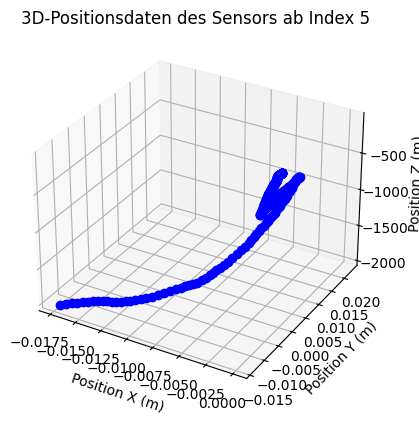

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Beispiel DataFrame laden
data = df

# Beschneide die Daten ab Index 5
data_subset = data.iloc[5:]

# Erstelle eine 3D-Figur
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plotte die Daten ab Index 5
ax.plot(data_subset['Position X(m)'], data_subset['Position Y(m)'], data_subset['Position Z(m)'], marker='o', linestyle='-', color='b')

# Füge Titel und Achsenbeschriftungen hinzu
ax.set_title('3D-Positionsdaten des Sensors ab Index 5')
ax.set_xlabel('Position X (m)')
ax.set_ylabel('Position Y (m)')
ax.set_zlabel('Position Z (m)')

# Zeige das Diagramm an
plt.show()

